In [1]:
from exp import *

import torchvision


import torchvision


In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
dm = DatasetManager('2017',224,'all','2017')

# dm.generate_dataset('train_images')

# dm.generate_dataset('valid_images')

In [4]:
train_imgs = dm.get_dataset_path('train_images')

In [5]:
def reload_dataset(dm,seed=1):
    random_seed(seed,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.1, max_lighting=0,p_affine=1, max_warp=0)

    data = ImageList.from_folder(dm.get_dataset_path('train_images').parent)\
    .split_by_folder(train=dm.get_dataset_path('train_images').name,
                   valid=dm.get_dataset_path('valid_images').name)\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=16)\
    .normalize()
    return data

data = reload_dataset(dm)

In [28]:
b = data.one_batch()

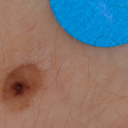

In [38]:
torchvision.transforms.ToPILImage()(b[0][0])

In [94]:
def plot_fan(alpha,beta):
    img = open_image(dm.get_dataset_path('train_images').ls()[0])
    img.show()
    f_image = torch.rfft(img.data,signal_ndim=3,onesided=True)

    f_image[:,:,:,1].mul_(alpha);
    f_image[:,:,:,0].mul_(beta);

    recon = torch.irfft(f_image,signal_ndim=3, onesided=True, signal_sizes=img.data.shape)

    display(torchvision.transforms.ToPILImage()(recon))

In [95]:
interact(plot_fan, alpha=widgets.FloatSlider(value=1,min=0,max=5,step=0.01,continuous_update=False),
        beta=widgets.FloatSlider(value=1,min=0,max=5,step=0.01,continuous_update=False), )

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='alpha', max=5.0, step=0.01)…

<function __main__.plot_fan(alpha, beta)>

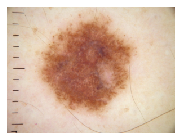

In [64]:
a = plot(1,2)

In [39]:




b[0].shape

f_image = torch.rfft(b[0],signal_ndim=3,onesided=True)

f_image[:,:,:,:,1].mul_(1.0);
f_image[:,:,:,:,0].mul_(1.0);

recon = torch.irfft(f_image,signal_ndim=3, onesided=True, signal_sizes=b[0].shape[1:])

b[0][0].shape

torch.Size([3, 128, 128])

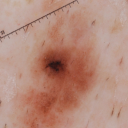

In [21]:
torchvision.transforms.ToPILImage()(recon[0])

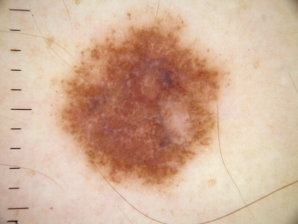

In [356]:
img_path = train_imgs.ls()[0]

img = open_image(img_path)

t = img.data

f_image = torch.rfft(t,signal_ndim=3,onesided=True)

f_image[:,:,:,1].mul_(1);

recon = torch.irfft(f_image,3, onesided=True, signal_sizes=t.shape)

torchvision.transforms.ToPILImage()(recon)

In [357]:
t = torch.rand(4,4)

In [358]:
t.random_()

tensor([[10120544.,  6044296., 10530860.,  4219455.],
        [13530542.,  5713200., 10301123., 10739630.],
        [ 2107617.,  1384761., 14154075.,   107422.],
        [ 5452251., 13178727., 10473558., 16425704.]])

In [359]:
from torchvision.models.resnet import Bottleneck
import types

In [360]:
r50 = models.resnet50(pretrained=True)
alpha_initial_value = 1.0
beta_initial_value = 1.0
gamma_initial_value = 1.0
def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        f_image = torch.rfft(identity,signal_ndim=3,onesided=True)

        f_image[:,:,:,:,1].mul_(self.alpha);
        f_image[:,:,:,:,0].mul_(self.beta);

        recon = torch.irfft(f_image,3, onesided=True, signal_sizes=out.shape[1:])
        
        
        out = out + (self.gamma * recon)

        out = self.relu(out)

        return out

def add_fattn_to_forward_func(a_module):
    a_module.forward = types.MethodType( forward,a_module)
    
def add_fattn_params(a_module):
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
    a_module.beta = nn.Parameter(torch.tensor(beta_initial_value))
    a_module.gamma = nn.Parameter(torch.tensor(gamma_initial_value))

    print(f'Added attention to {a_module}')
    
    
def change_basic_blocks(a_module):
    if not isinstance(a_module, Bottleneck): return
    add_fattn_params(a_module)
    add_fattn_to_forward_func(a_module)

In [361]:
apply_leaf(r50, change_basic_blocks)

Added attention to Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Added attention to Bottleneck(
  (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), 

In [362]:
from exp import *

dm = DatasetManager('2017',224,'all','2017')

# dm.generate_dataset('train_images')

# dm.generate_dataset('valid_images')

In [363]:
len(dm.get_dataset_path('train_images').ls())

2000

In [364]:
len(dm.get_dataset_path('valid_images').ls())

150

In [365]:
def reload_dataset(dm,seed=1):
    random_seed(seed,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.1, max_lighting=0,p_affine=1, max_warp=0)

    data = ImageList.from_folder(dm.get_dataset_path('train_images').parent)\
    .split_by_folder(train=dm.get_dataset_path('train_images').name,
                   valid=dm.get_dataset_path('valid_images').name)\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=16)\
    .normalize()
    return data

data = reload_dataset(dm)

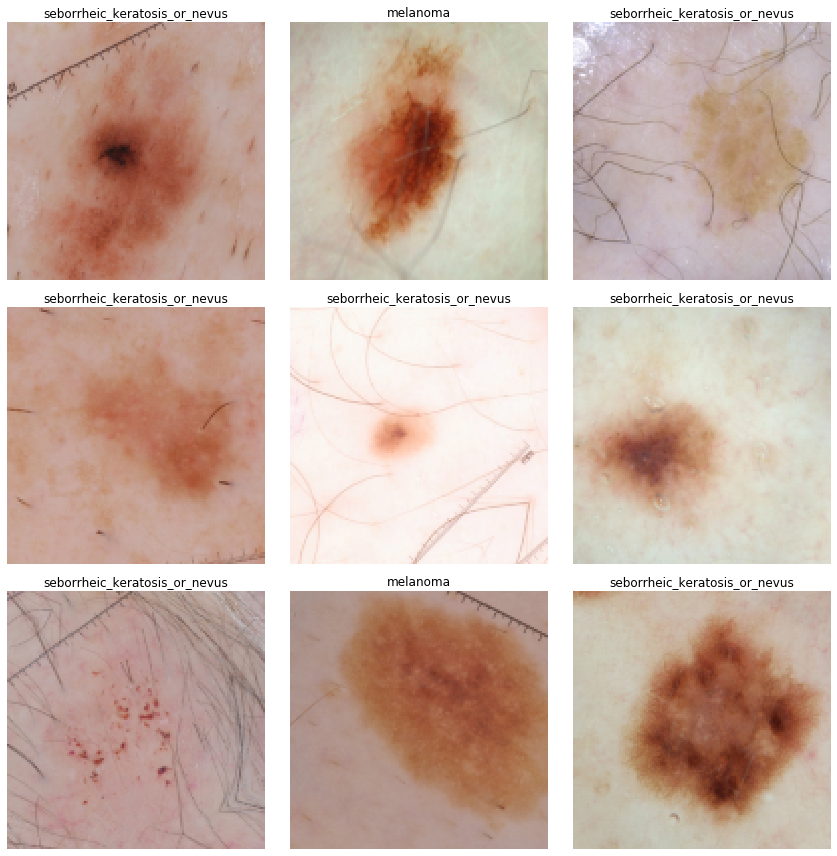

In [366]:
data.show_batch(3)

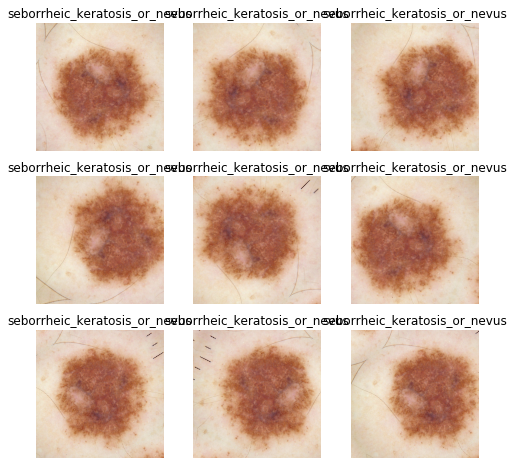

In [244]:
def _plot(i,j,ax,img_index=0):
    x,y = data.train_ds[img_index]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [245]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 seborrheic_keratosis_or_nevus    1626
melanoma                          374
dtype: int64 

 valid_count: 
 seborrheic_keratosis_or_nevus    120
melanoma                          30
dtype: int64
ratios:
seborrheic_keratosis_or_nevus    0.073801
melanoma                         0.080214
dtype: float64 %


# Lets test a baseline

In [367]:
data = reload_dataset(dm)

In [368]:
bottlenecks = [bn for bn in r50.modules() if isinstance(bn,Bottleneck)]

class Alphas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()
class Betas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.beta.item(),m.beta.item()
class Gammas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.gamma.item(),m.gamma.item()

In [369]:
bottlenecks[0].alpha

Parameter containing:
tensor(1., requires_grad=True)

In [374]:
random_seed(1,True)
learn = cnn_learner(data, lambda x: r50, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph,
                                     partial(Alphas, modules=bottlenecks),
                                    partial(Betas, modules=bottlenecks),
                                    partial(Gammas, modules=bottlenecks),

                                      
], 
                        pretrained=True)

In [376]:
learn.unfreeze()

[{'melanoma': 10.695187165775401}, {'seborrheic_keratosis_or_nevus': 2.4600246002460024}]


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.999215,0.679921,0.220000,0.780000,0.687500,00:12


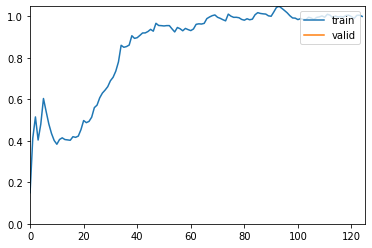

Better model found at epoch 0 with accuracy value: 0.7799999713897705.


In [377]:
train_learner(learn,epochs=1)

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.210351,0.770072,0.360000,0.640000,0.617778,00:09
1,1.064224,0.636441,0.353333,0.646667,0.673333,00:09
2,0.925013,0.608679,0.313333,0.686667,0.659167,00:09
3,0.839510,0.630742,0.333333,0.666667,0.645833,00:09


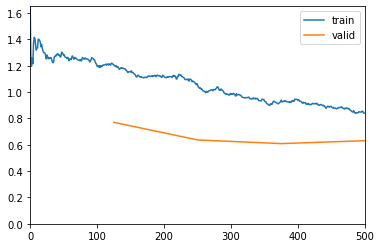

In [327]:
random_seed(1,True)
learn.fit_one_cycle(4,max_lr=slice(1.10E-04))

In [328]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.239595,0.584804,0.293333,0.706667,0.663333,00:12
1,0.105761,0.590901,0.300000,0.700000,0.691667,00:12
2,0.377470,0.694060,0.320000,0.680000,0.570278,00:12
3,0.705321,0.685300,0.266667,0.733333,0.578889,00:12
4,0.694995,0.608833,0.226667,0.773333,0.613333,00:12
5,0.615181,0.559765,0.213333,0.786667,0.649444,00:12
6,0.570431,0.568469,0.226667,0.773333,0.684167,00:12
7,0.548726,0.546139,0.220000,0.780000,0.685556,00:12
8,0.585226,0.546953,0.226667,0.773333,0.699722,00:12
9,0.571054,0.521419,0.193333,0.806667,0.711389,00:12


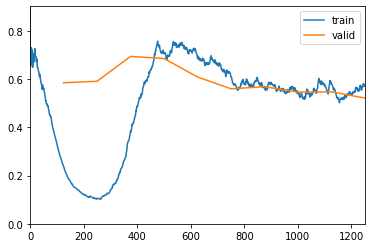

In [329]:
random_seed(1,True)
learn.fit_one_cycle(10,max_lr=slice(1.10E-04))

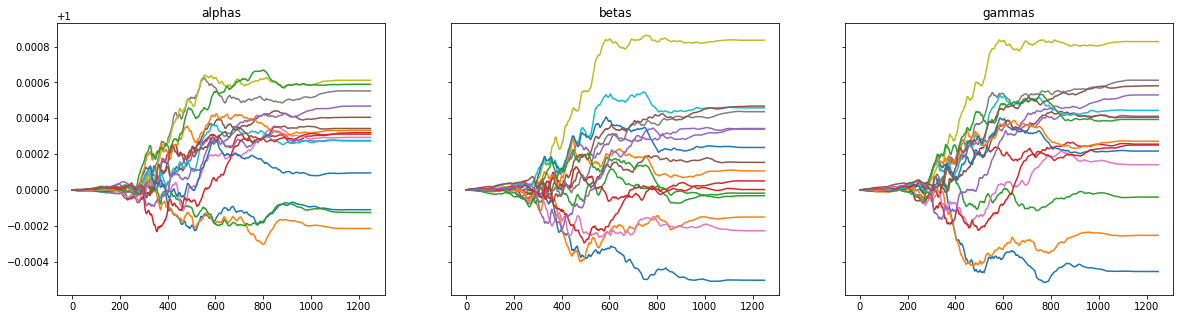

In [330]:
ps = list(learn.model.named_parameters())

ls = [n for n in ps if 'gamma' in n[0]]
new_params = ['alphas','betas','gammas']

fig, axs = plt.subplots(1,3,figsize=(20,5), sharey=True)
for idx, ax in enumerate(axs):
    for i in range(len(ls)):
        ax.plot(learn.__getattribute__(new_params[idx]).stats[0][i])
        ax.set_title(new_params[idx])

In [331]:
random_seed(1,True)
learn = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph], 
                        pretrained=True)

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.210329,0.770039,0.360000,0.640000,0.617500,00:05
1,1.063902,0.636237,0.353333,0.646667,0.674722,00:05
2,0.924814,0.608010,0.313333,0.686667,0.659444,00:05
3,0.839407,0.630412,0.333333,0.666667,0.645555,00:05


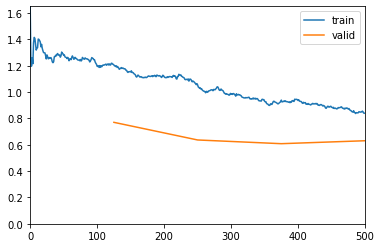

In [332]:
random_seed(1,True)
learn.fit_one_cycle(4,max_lr=slice(1.10E-04))

In [333]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.239838,0.584440,0.293333,0.706667,0.662778,00:07
1,0.105818,0.591607,0.306667,0.693333,0.691389,00:07
2,0.373008,0.699061,0.320000,0.680000,0.561944,00:07
3,0.690484,0.679354,0.293333,0.706667,0.592778,00:07
4,0.672686,0.639764,0.226667,0.773333,0.595833,00:07
5,0.625732,0.591653,0.213333,0.786667,0.632778,00:07
6,0.566788,0.622482,0.226667,0.773333,0.661111,00:07
7,0.548385,0.536900,0.220000,0.780000,0.704444,00:07
8,0.585224,0.557657,0.213333,0.786667,0.700556,00:07
9,0.562268,0.520254,0.213333,0.786667,0.722778,00:07


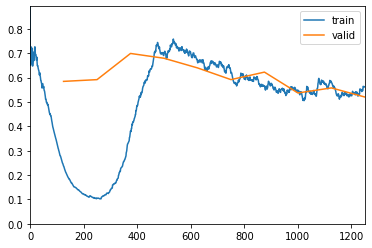

In [334]:
random_seed(1,True)
learn.fit_one_cycle(10,max_lr=slice(1.10E-04))

[{'melanoma': 10.695187165775401}, {'seborrheic_keratosis_or_nevus': 2.4600246002460024}]


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.182402,0.834039,0.526667,0.473333,0.603889,00:07
1,1.066874,0.752017,0.380000,0.620000,0.696389,00:07
2,0.982024,0.814458,0.400000,0.600000,0.659722,00:07
3,0.927413,0.901903,0.426667,0.573333,0.637500,00:07
4,0.983816,0.828170,0.340000,0.660000,0.669722,00:07
5,0.967644,0.963435,0.413333,0.586667,0.738333,00:07
6,0.972956,0.784360,0.273333,0.726667,0.688889,00:07
7,0.836439,0.781458,0.253333,0.746667,0.701944,00:07
8,0.830370,0.801166,0.260000,0.740000,0.721111,00:07
9,0.796462,0.679000,0.200000,0.800000,0.768055,00:07


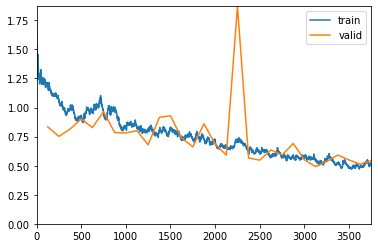

Better model found at epoch 0 with accuracy value: 0.47333332896232605.
Better model found at epoch 1 with accuracy value: 0.6200000047683716.
Better model found at epoch 4 with accuracy value: 0.6600000262260437.
Better model found at epoch 6 with accuracy value: 0.7266666889190674.
Better model found at epoch 7 with accuracy value: 0.746666669845581.
Better model found at epoch 9 with accuracy value: 0.800000011920929.
Better model found at epoch 22 with accuracy value: 0.8399999737739563.
Added attention to Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.180616,0.831296,0.493333,0.506667,0.600278,00:12
1,1.066143,0.787914,0.446667,0.553333,0.654722,00:12
2,1.033995,0.774595,0.340000,0.660000,0.669722,00:12
3,0.975705,0.797185,0.353333,0.646667,0.703056,00:12
4,1.119232,0.716035,0.353333,0.646667,0.745278,00:12
5,0.974884,0.716657,0.313333,0.686667,0.746111,00:12
6,0.971333,1.129490,0.393333,0.606667,0.580000,00:12
7,0.865153,0.870458,0.213333,0.786667,0.643055,00:12
8,0.883799,0.908391,0.253333,0.746667,0.674167,00:12
9,0.848765,0.747106,0.246667,0.753333,0.761111,00:12


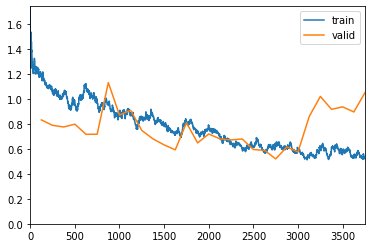

Better model found at epoch 0 with accuracy value: 0.5066666603088379.
Better model found at epoch 1 with accuracy value: 0.5533333420753479.
Better model found at epoch 2 with accuracy value: 0.6600000262260437.
Better model found at epoch 5 with accuracy value: 0.6866666674613953.
Better model found at epoch 7 with accuracy value: 0.7866666913032532.
Better model found at epoch 17 with accuracy value: 0.8066666722297668.
Better model found at epoch 22 with accuracy value: 0.8399999737739563.
[{'melanoma': 10.695187165775401}, {'seborrheic_keratosis_or_nevus': 2.4600246002460024}]


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.104008,0.786834,0.440000,0.560000,0.643055,00:07
1,1.086271,0.717208,0.426667,0.573333,0.720000,00:07
2,0.957664,0.764406,0.380000,0.620000,0.702222,00:07
3,0.972712,1.006043,0.413333,0.586667,0.682500,00:07
4,0.985085,0.943437,0.260000,0.740000,0.711111,00:07
5,0.931667,0.940660,0.306667,0.693333,0.721944,00:07
6,1.014367,1.271439,0.320000,0.680000,0.719167,00:07
7,0.908164,0.679406,0.360000,0.640000,0.737500,00:07
8,0.860506,0.829800,0.253333,0.746667,0.778889,00:07
9,0.794782,0.686287,0.280000,0.720000,0.760556,00:07


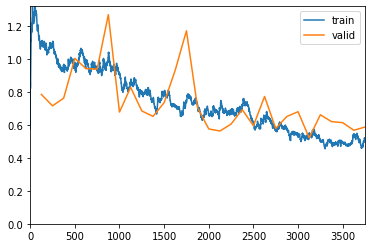

Better model found at epoch 0 with accuracy value: 0.5600000023841858.
Better model found at epoch 1 with accuracy value: 0.5733333230018616.
Better model found at epoch 2 with accuracy value: 0.6200000047683716.
Better model found at epoch 4 with accuracy value: 0.7400000095367432.
Better model found at epoch 8 with accuracy value: 0.746666669845581.
Better model found at epoch 12 with accuracy value: 0.753333330154419.
Better model found at epoch 15 with accuracy value: 0.800000011920929.
Better model found at epoch 21 with accuracy value: 0.8133333325386047.
Better model found at epoch 22 with accuracy value: 0.8399999737739563.
Better model found at epoch 23 with accuracy value: 0.846666693687439.
Better model found at epoch 24 with accuracy value: 0.8733333349227905.
Added attention to Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.102999,0.797670,0.446667,0.553333,0.638333,00:12
1,1.076582,0.744644,0.433333,0.566667,0.713056,00:12
2,0.952229,0.670253,0.400000,0.600000,0.765556,00:12
3,0.944315,0.668146,0.300000,0.700000,0.811389,00:12
4,0.944803,1.190157,0.306667,0.693333,0.662222,00:12
5,0.924699,0.846008,0.333333,0.666667,0.771945,00:12
6,1.041488,0.897254,0.380000,0.620000,0.701667,00:12
7,0.893912,1.461230,0.233333,0.766667,0.728056,00:12
8,0.829456,1.243200,0.413333,0.586667,0.699722,00:12
9,0.900801,0.984145,0.246667,0.753333,0.709167,00:12


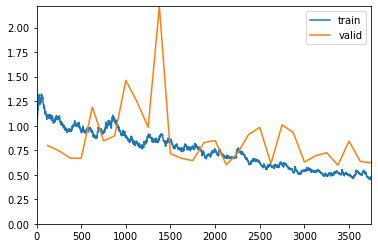

Better model found at epoch 0 with accuracy value: 0.5533333420753479.
Better model found at epoch 1 with accuracy value: 0.5666666626930237.
Better model found at epoch 2 with accuracy value: 0.6000000238418579.
Better model found at epoch 3 with accuracy value: 0.699999988079071.
Better model found at epoch 7 with accuracy value: 0.7666666507720947.
Better model found at epoch 10 with accuracy value: 0.7933333516120911.
Better model found at epoch 13 with accuracy value: 0.8333333134651184.
Better model found at epoch 20 with accuracy value: 0.8533333539962769.
Better model found at epoch 26 with accuracy value: 0.8600000143051147.
Better model found at epoch 27 with accuracy value: 0.8666666746139526.
Better model found at epoch 29 with accuracy value: 0.8733333349227905.
[{'melanoma': 10.695187165775401}, {'seborrheic_keratosis_or_nevus': 2.4600246002460024}]


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.117818,0.815434,0.460000,0.540000,0.593056,00:07
1,1.037453,0.800501,0.473333,0.526667,0.661389,00:07
2,1.036339,0.709460,0.286667,0.713333,0.735000,00:07
3,1.053853,0.744803,0.266667,0.733333,0.776389,00:07
4,0.986710,0.807600,0.320000,0.680000,0.756944,00:07
5,0.882370,0.794116,0.333333,0.666667,0.743056,00:07
6,0.833778,0.658312,0.260000,0.740000,0.769722,00:07
7,0.900359,0.554786,0.206667,0.793333,0.818056,00:07
8,0.929179,0.600120,0.226667,0.773333,0.779167,00:07
9,0.836452,0.620220,0.200000,0.800000,0.769722,00:07


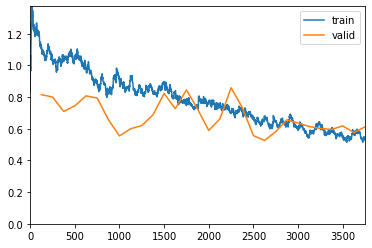

Better model found at epoch 0 with accuracy value: 0.5400000214576721.
Better model found at epoch 2 with accuracy value: 0.7133333086967468.
Better model found at epoch 3 with accuracy value: 0.7333333492279053.
Better model found at epoch 6 with accuracy value: 0.7400000095367432.
Better model found at epoch 7 with accuracy value: 0.7933333516120911.
Better model found at epoch 9 with accuracy value: 0.800000011920929.
Better model found at epoch 20 with accuracy value: 0.8199999928474426.
Better model found at epoch 28 with accuracy value: 0.8266666531562805.
Added attention to Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.119354,0.810434,0.460000,0.540000,0.591111,00:12
1,1.035861,0.807045,0.493333,0.506667,0.666111,00:12
2,1.044165,0.752611,0.360000,0.640000,0.713611,00:12
3,0.996864,0.798759,0.360000,0.640000,0.685556,00:12
4,0.951159,0.843039,0.413333,0.586667,0.648333,00:12
5,1.011639,0.721629,0.346667,0.653333,0.753889,00:12
6,0.857678,0.849176,0.373333,0.626667,0.702778,00:12
7,0.892088,0.827468,0.246667,0.753333,0.736667,00:12
8,0.874011,0.816900,0.346667,0.653333,0.659167,00:12
9,0.819202,0.655688,0.233333,0.766667,0.789445,00:12


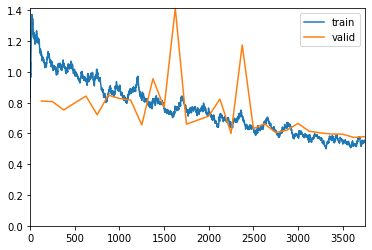

Better model found at epoch 0 with accuracy value: 0.5400000214576721.
Better model found at epoch 2 with accuracy value: 0.6399999856948853.
Better model found at epoch 5 with accuracy value: 0.653333306312561.
Better model found at epoch 7 with accuracy value: 0.753333330154419.
Better model found at epoch 9 with accuracy value: 0.7666666507720947.
Better model found at epoch 11 with accuracy value: 0.7799999713897705.
Better model found at epoch 15 with accuracy value: 0.7933333516120911.
Better model found at epoch 19 with accuracy value: 0.8399999737739563.
[{'melanoma': 10.695187165775401}, {'seborrheic_keratosis_or_nevus': 2.4600246002460024}]


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.139305,0.774354,0.406667,0.593333,0.640000,00:07
1,1.018276,0.760589,0.393333,0.606667,0.663333,00:07
2,1.024169,0.759436,0.373333,0.626667,0.739167,00:07
3,1.002235,0.894634,0.353333,0.646667,0.731111,00:07
4,0.981911,0.890161,0.320000,0.680000,0.671389,00:07
5,0.981176,0.960254,0.413333,0.586667,0.671111,00:07
6,0.873597,0.817909,0.366667,0.633333,0.687778,00:07
7,0.873474,0.757416,0.293333,0.706667,0.729722,00:07
8,0.829044,1.100251,0.260000,0.740000,0.627917,00:07
9,0.826304,0.717419,0.253333,0.746667,0.728611,00:07


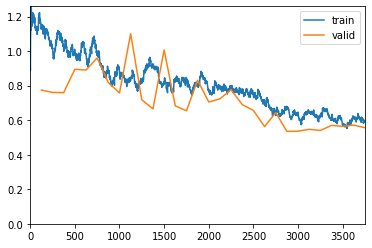

Better model found at epoch 0 with accuracy value: 0.5933333039283752.
Better model found at epoch 1 with accuracy value: 0.6066666841506958.
Better model found at epoch 2 with accuracy value: 0.6266666650772095.
Better model found at epoch 3 with accuracy value: 0.6466666460037231.
Better model found at epoch 4 with accuracy value: 0.6800000071525574.
Better model found at epoch 7 with accuracy value: 0.7066666483879089.
Better model found at epoch 8 with accuracy value: 0.7400000095367432.
Better model found at epoch 9 with accuracy value: 0.746666669845581.
Better model found at epoch 11 with accuracy value: 0.7666666507720947.
Better model found at epoch 13 with accuracy value: 0.7733333110809326.
Better model found at epoch 19 with accuracy value: 0.8199999928474426.
Added attention to Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.140407,0.777520,0.393333,0.606667,0.636667,00:12
1,1.023960,0.777167,0.386667,0.613333,0.660000,00:12
2,0.993722,0.836915,0.393333,0.606667,0.683333,00:12
3,0.977593,1.052003,0.346667,0.653333,0.692500,00:12
4,0.996012,0.926819,0.346667,0.653333,0.718333,00:12
5,0.921144,0.754637,0.386667,0.613333,0.699167,00:12
6,0.857308,0.778848,0.280000,0.720000,0.750833,00:12
7,0.846446,0.660591,0.306667,0.693333,0.755556,00:12
8,0.919454,0.667165,0.240000,0.760000,0.736944,00:12
9,0.815481,0.678707,0.213333,0.786667,0.777222,00:12


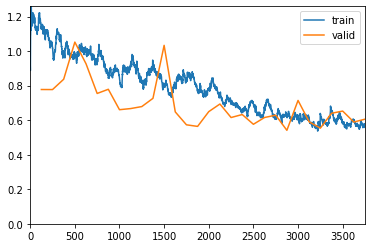

Better model found at epoch 0 with accuracy value: 0.6066666841506958.
Better model found at epoch 1 with accuracy value: 0.6133333444595337.
Better model found at epoch 3 with accuracy value: 0.653333306312561.
Better model found at epoch 6 with accuracy value: 0.7200000286102295.
Better model found at epoch 8 with accuracy value: 0.7599999904632568.
Better model found at epoch 9 with accuracy value: 0.7866666913032532.
Better model found at epoch 24 with accuracy value: 0.8333333134651184.
[{'melanoma': 10.695187165775401}, {'seborrheic_keratosis_or_nevus': 2.4600246002460024}]


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.194850,0.854277,0.460000,0.540000,0.596667,00:07
1,1.066154,0.773394,0.386667,0.613333,0.688333,00:07
2,1.040272,0.759742,0.386667,0.613333,0.732222,00:07
3,1.032915,0.769172,0.313333,0.686667,0.715000,00:07
4,1.038555,0.711262,0.266667,0.733333,0.779722,00:07
5,1.008887,0.873743,0.366667,0.633333,0.681667,00:07
6,0.866313,1.059713,0.306667,0.693333,0.573611,00:07
7,0.963893,0.755127,0.346667,0.653333,0.682222,00:07
8,0.857491,2.381325,0.533333,0.466667,0.487222,00:07
9,0.872589,0.733178,0.260000,0.740000,0.716667,00:07


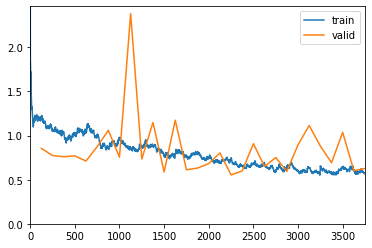

Better model found at epoch 0 with accuracy value: 0.5400000214576721.
Better model found at epoch 1 with accuracy value: 0.6133333444595337.
Better model found at epoch 3 with accuracy value: 0.6866666674613953.
Better model found at epoch 4 with accuracy value: 0.7333333492279053.
Better model found at epoch 9 with accuracy value: 0.7400000095367432.
Better model found at epoch 14 with accuracy value: 0.8133333325386047.
Better model found at epoch 20 with accuracy value: 0.8333333134651184.
Better model found at epoch 26 with accuracy value: 0.8399999737739563.
Added attention to Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.191523,0.851522,0.453333,0.546667,0.596389,00:12
1,1.066797,0.795771,0.400000,0.600000,0.678333,00:12
2,1.029621,0.673678,0.346667,0.653333,0.743889,00:12
3,1.030356,0.981485,0.413333,0.586667,0.623889,00:12
4,1.136803,0.963134,0.313333,0.686667,0.721389,00:12
5,0.942813,0.750162,0.326667,0.673333,0.742500,00:12
6,0.859219,0.590102,0.300000,0.700000,0.784167,00:12
7,0.831342,0.721155,0.333333,0.666667,0.672778,00:12
8,0.870318,0.665752,0.306667,0.693333,0.760556,00:12
9,0.861929,0.811774,0.193333,0.806667,0.741667,00:12


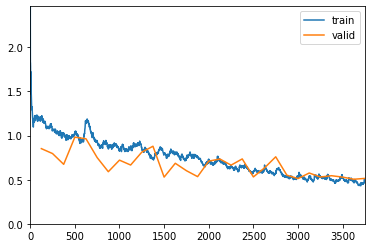

Better model found at epoch 0 with accuracy value: 0.54666668176651.
Better model found at epoch 1 with accuracy value: 0.6000000238418579.
Better model found at epoch 2 with accuracy value: 0.653333306312561.
Better model found at epoch 4 with accuracy value: 0.6866666674613953.
Better model found at epoch 6 with accuracy value: 0.699999988079071.
Better model found at epoch 9 with accuracy value: 0.8066666722297668.
Better model found at epoch 14 with accuracy value: 0.8333333134651184.
Better model found at epoch 19 with accuracy value: 0.8399999737739563.
Better model found at epoch 26 with accuracy value: 0.8666666746139526.
[{'melanoma': 10.695187165775401}, {'seborrheic_keratosis_or_nevus': 2.4600246002460024}]


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.210853,0.888132,0.473333,0.526667,0.619722,00:07
1,1.077914,0.826543,0.386667,0.613333,0.648056,00:07
2,0.990196,0.951618,0.420000,0.580000,0.631667,00:07
3,1.016855,0.757664,0.320000,0.680000,0.725000,00:07
4,0.997104,0.782618,0.320000,0.680000,0.760833,00:07
5,1.027590,0.803573,0.393333,0.606667,0.670278,00:07
6,0.866741,0.720806,0.366667,0.633333,0.756111,00:07
7,0.846197,1.018719,0.226667,0.773333,0.685833,00:07
8,0.869583,0.723705,0.233333,0.766667,0.725000,00:07
9,0.908730,1.010288,0.246667,0.753333,0.688889,00:07


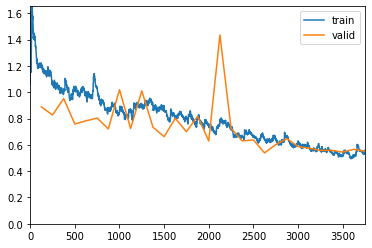

Better model found at epoch 0 with accuracy value: 0.5266666412353516.
Better model found at epoch 1 with accuracy value: 0.6133333444595337.
Better model found at epoch 3 with accuracy value: 0.6800000071525574.
Better model found at epoch 7 with accuracy value: 0.7733333110809326.
Better model found at epoch 13 with accuracy value: 0.7799999713897705.
Better model found at epoch 20 with accuracy value: 0.7933333516120911.
Added attention to Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downs

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.208901,0.889029,0.460000,0.540000,0.618333,00:12
1,1.078172,0.779515,0.373333,0.626667,0.674167,00:12
2,1.014930,0.870300,0.413333,0.586667,0.667222,00:12
3,0.948543,0.817632,0.393333,0.606667,0.661667,00:12
4,0.966858,0.832582,0.320000,0.680000,0.744167,00:12
5,0.996471,0.707587,0.333333,0.666667,0.704722,00:12
6,0.920067,1.005325,0.266667,0.733333,0.715833,00:12
7,0.907127,1.005695,0.306667,0.693333,0.586389,00:12
8,0.889797,0.721133,0.233333,0.766667,0.746389,00:12
9,0.720984,0.653314,0.273333,0.726667,0.761111,00:12


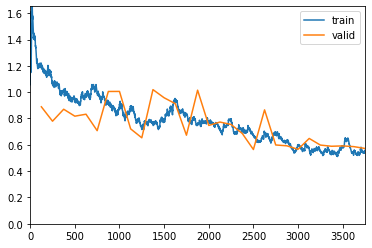

Better model found at epoch 0 with accuracy value: 0.5400000214576721.
Better model found at epoch 1 with accuracy value: 0.6266666650772095.
Better model found at epoch 4 with accuracy value: 0.6800000071525574.
Better model found at epoch 6 with accuracy value: 0.7333333492279053.
Better model found at epoch 8 with accuracy value: 0.7666666507720947.
Better model found at epoch 11 with accuracy value: 0.7799999713897705.
Better model found at epoch 13 with accuracy value: 0.7866666913032532.
Better model found at epoch 19 with accuracy value: 0.8266666531562805.
[{'melanoma': 10.695187165775401}, {'seborrheic_keratosis_or_nevus': 2.4600246002460024}]


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.149862,0.828617,0.466667,0.533333,0.616389,00:07
1,1.052854,0.819064,0.426667,0.573333,0.630000,00:07
2,0.971851,0.852084,0.360000,0.640000,0.665556,00:07
3,1.013365,0.716649,0.246667,0.753333,0.769444,00:07
4,1.113292,0.956814,0.360000,0.640000,0.671111,00:07
5,0.930163,1.116451,0.426667,0.573333,0.617778,00:07
6,0.976468,0.835557,0.333333,0.666667,0.696111,00:07
7,0.852740,0.833038,0.386667,0.613333,0.713611,00:07
8,0.883159,0.737448,0.400000,0.600000,0.686111,00:07
9,0.763144,0.684470,0.266667,0.733333,0.729722,00:07


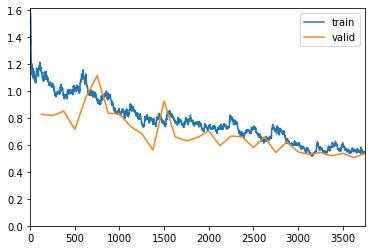

Better model found at epoch 0 with accuracy value: 0.5333333611488342.
Better model found at epoch 1 with accuracy value: 0.5733333230018616.
Better model found at epoch 2 with accuracy value: 0.6399999856948853.
Better model found at epoch 3 with accuracy value: 0.753333330154419.
Better model found at epoch 11 with accuracy value: 0.7733333110809326.
Better model found at epoch 13 with accuracy value: 0.7933333516120911.
Better model found at epoch 15 with accuracy value: 0.8066666722297668.
Better model found at epoch 20 with accuracy value: 0.8266666531562805.
Better model found at epoch 24 with accuracy value: 0.8333333134651184.
Better model found at epoch 26 with accuracy value: 0.8666666746139526.
Added attention to Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.143874,0.818847,0.453333,0.546667,0.621389,00:12
1,1.074741,0.789180,0.413333,0.586667,0.659722,00:12
2,0.980776,0.917910,0.373333,0.626667,0.643056,00:12
3,1.062844,0.694428,0.266667,0.733333,0.763611,00:12
4,1.001278,0.880359,0.333333,0.666667,0.673056,00:12
5,0.901002,1.004331,0.373333,0.626667,0.696667,00:12
6,0.919593,1.179633,0.313333,0.686667,0.705833,00:12
7,0.850588,0.666542,0.306667,0.693333,0.761944,00:12
8,0.847415,0.605737,0.206667,0.793333,0.783055,00:12
9,0.790948,1.061176,0.300000,0.700000,0.718472,00:12


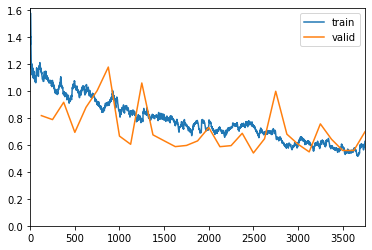

Better model found at epoch 0 with accuracy value: 0.54666668176651.
Better model found at epoch 1 with accuracy value: 0.5866666436195374.
Better model found at epoch 2 with accuracy value: 0.6266666650772095.
Better model found at epoch 3 with accuracy value: 0.7333333492279053.
Better model found at epoch 8 with accuracy value: 0.7933333516120911.
Better model found at epoch 13 with accuracy value: 0.8066666722297668.
Better model found at epoch 19 with accuracy value: 0.8133333325386047.
Better model found at epoch 24 with accuracy value: 0.8333333134651184.
[{'melanoma': 10.695187165775401}, {'seborrheic_keratosis_or_nevus': 2.4600246002460024}]


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.085423,0.842045,0.446667,0.553333,0.601667,00:07
1,1.100514,0.804126,0.340000,0.660000,0.680278,00:07
2,0.996267,0.811784,0.333333,0.666667,0.695278,00:07
3,1.056200,0.961636,0.280000,0.720000,0.680556,00:07
4,1.021519,0.949894,0.366667,0.633333,0.658333,00:07
5,0.991387,0.839613,0.306667,0.693333,0.771945,00:07
6,0.909152,0.598143,0.346667,0.653333,0.778333,00:07
7,0.937154,0.652799,0.300000,0.700000,0.759444,00:07
8,0.822613,0.724873,0.266667,0.733333,0.670556,00:07
9,0.785443,0.699759,0.300000,0.700000,0.640556,00:07


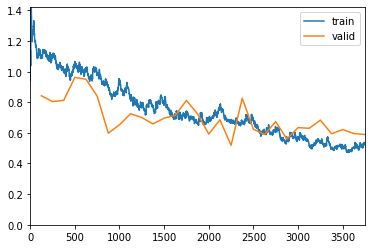

Better model found at epoch 0 with accuracy value: 0.5533333420753479.
Better model found at epoch 1 with accuracy value: 0.6600000262260437.
Better model found at epoch 2 with accuracy value: 0.6666666865348816.
Better model found at epoch 3 with accuracy value: 0.7200000286102295.
Better model found at epoch 8 with accuracy value: 0.7333333492279053.
Better model found at epoch 11 with accuracy value: 0.7599999904632568.
Better model found at epoch 12 with accuracy value: 0.8199999928474426.
Better model found at epoch 16 with accuracy value: 0.8533333539962769.
Added attention to Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.083545,0.837893,0.446667,0.553333,0.600833,00:12
1,1.111836,0.853642,0.386667,0.613333,0.656111,00:12
2,1.016406,0.749323,0.413333,0.586667,0.688611,00:12
3,0.964715,0.916557,0.393333,0.606667,0.666944,00:12
4,0.968281,1.019750,0.373333,0.626667,0.620278,00:12
5,0.971484,0.915151,0.366667,0.633333,0.710278,00:12
6,0.895595,0.878206,0.313333,0.686667,0.659722,00:12
7,0.869384,0.743150,0.293333,0.706667,0.747500,00:12
8,0.869660,0.634560,0.280000,0.720000,0.748611,00:12
9,0.824499,1.561925,0.266667,0.733333,0.562222,00:12


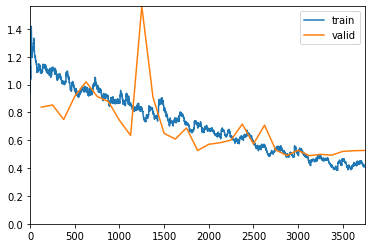

Better model found at epoch 0 with accuracy value: 0.5533333420753479.
Better model found at epoch 1 with accuracy value: 0.6133333444595337.
Better model found at epoch 4 with accuracy value: 0.6266666650772095.
Better model found at epoch 5 with accuracy value: 0.6333333253860474.
Better model found at epoch 6 with accuracy value: 0.6866666674613953.
Better model found at epoch 7 with accuracy value: 0.7066666483879089.
Better model found at epoch 8 with accuracy value: 0.7200000286102295.
Better model found at epoch 9 with accuracy value: 0.7333333492279053.
Better model found at epoch 11 with accuracy value: 0.746666669845581.
Better model found at epoch 12 with accuracy value: 0.7666666507720947.
Better model found at epoch 17 with accuracy value: 0.8066666722297668.
Better model found at epoch 20 with accuracy value: 0.8333333134651184.
Better model found at epoch 21 with accuracy value: 0.8533333539962769.
Better model found at epoch 25 with accuracy value: 0.8666666746139526.
B

In [380]:
seeds = [1,2,3,4,5,6,7,8]
epochs = 30

for s in seeds:
    data = reload_dataset(dm)    
    random_seed(1,True)

    learn = cnn_learner(data,models.resnet50, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                                ], pretrained=True)
    learn.unfreeze()
    learn.summary()


    train_learner(learn,epochs=epochs, seed=s, balanced=True, lr=1.74e-04)
    l1 = list(map(lambda x: x[1], learn.recorder.metrics))
    
    
    
    
    #Con attention
    data = reload_dataset(dm)    

    r50_attn = models.resnet50(pretrained=True)
    apply_leaf(r50_attn, change_basic_blocks)
    random_seed(1,True)

    bottlenecks = [bn for bn in r50_attn.modules() if isinstance(bn,Bottleneck)]

    learn_attn = cnn_learner(data, lambda x: r50_attn, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                             partial(Alphas, modules=bottlenecks),
                            partial(Betas, modules=bottlenecks),
                            partial(Gammas, modules=bottlenecks)
                                ], pretrained=True)
    learn_attn.unfreeze()
#     learn_attn.summary()
    

    # learn_b0.summary()
    train_learner(learn_attn,epochs=epochs, seed=s,lr=1.74e-04)
    
   
    l2 = list(map(lambda x: x[1], learn_attn.recorder.metrics))
    
    f = open(f'fan_run_seed_{s}.txt','w+')
    f.write('Baseline, With FAN\n')
    run = ''.join(map(str,[f'{a.item()},{b.item()}\n' for a,b in zip(l1,l2) ]))
    f.write(run)
    f.close()

In [ ]:
train_learner()